In [1]:
from random import sample

import warnings
import torch
from torch import device, cuda, autocast
from torch.cuda.amp import GradScaler
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

import flyvision
from flyvision.utils.activity_utils import LayerActivity
from flyvision_ans import DECODING_CELLS
import wandb
from conv_models import DecodingImagesCNN
from from_retina_to_connectome_utils import layer_activations_to_decoding_images, predictions_and_corrects_from_model_results, update_results_df, update_running_loss, initialize_results_df
from from_video_to_training_batched_funcs import get_files_from_directory, select_random_videos, paths_to_labels
from from_image_to_video import image_paths_to_sequences
from utils import plot_weber_fraction
from logs_to_wandb import log_running_stats_to_wandb, log_validation_stats_to_wandb


warnings.filterwarnings(
    'ignore',
    message='invalid value encountered in cast',
    category=RuntimeWarning,
    module='wandb.sdk.data_types.image'
)

device_type = "cuda" if cuda.is_available() else "cpu"
DEVICE = device(device_type)
torch.manual_seed(42)

last_good_frame = 2

TRAINING_DATA_DIR = "images/easy_v2"
TESTING_DATA_DIR = "images/easy_images"
VALIDATION_DATA_DIR = "images/easyval_images"

debugging = False
debug_length = 20
wandb_ = True
wandb_images_every = 100

small = False
small_length = 2000
test_every = 2 if small else 10
batch_size = 32 if small else 128

num_epochs = 1

channel_sizes = [16, 32, 64]
mult_size = 1.5
channel_sizes = [int(a * mult_size) for a in channel_sizes]
dropout = .3
max_lr = 0.02
base_lr = 0.01
weight_decay = 0.001

use_one_cycle_lr = True

cell_type_plot = "TmY18"

model_config = {
    "debugging": debugging,
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "channel_sizes": channel_sizes,
    "dropout": dropout,
    "base_lr": base_lr,
    "max_lr": max_lr,
    "weight_decay": weight_decay
}

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
network_view = flyvision.NetworkView(flyvision.results_dir / "opticflow/000/0000")
network = network_view.init_network(chkpt="best_chkpt")
dt = 1 / 100
extent, kernel_size = 15, 13
receptors = flyvision.rendering.BoxEye(extent=extent, kernel_size=kernel_size)

training_videos = get_files_from_directory(TRAINING_DATA_DIR)
test_videos = get_files_from_directory(TESTING_DATA_DIR)
validation_videos = get_files_from_directory(TESTING_DATA_DIR)

if small:
    training_videos = sample(training_videos, small_length)
    test_videos = sample(test_videos, small_length)
    validation_videos = sample(validation_videos, int(small_length / 5))
    

if len(training_videos) == 0:
    print("I can't find any training images or videos!")

In [3]:
model = DecodingImagesCNN(
    out_channels_1 = channel_sizes[0],
    out_channels_2 = channel_sizes[1],
    out_channels_3 = channel_sizes[2],
    dropout = dropout
).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=base_lr, weight_decay=weight_decay)

# Initialize the scheduler
iterations = debug_length if debugging else len(training_videos) // batch_size
if use_one_cycle_lr:
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=int(num_epochs * iterations / test_every), anneal_strategy='linear')

scaler = GradScaler()

# Initialize the loss function
criterion = BCEWithLogitsLoss()

In [4]:
# Start wandb run
from logs_to_wandb import log_images_to_wandb


if wandb_:
    wandb.init(project='la_classification', config=model_config)

results = initialize_results_df()

# Training loop
for epoch in range(num_epochs):
    model.train()
    already_selected = []
    running_loss = 0.0
    total_correct = 0
    total = 0
    for i in tqdm(range(iterations)):
        batch_files, already_selected = select_random_videos(
            training_videos, batch_size, already_selected
        )
        labels = paths_to_labels(batch_files)
        batch_sequences = image_paths_to_sequences(batch_files)
        rendered_sequences = receptors(batch_sequences)
        
        layer_activations = []
        for rendered_sequence in rendered_sequences:
            # rendered sequences are in RGB; move it to 0-1 for better training
            rendered_sequence = torch.div(rendered_sequence, 255)
            # TODO: try to run this on cpu to multithread it
            simulation = network.simulate(rendered_sequence[None], dt)
            layer_activations.append(
                LayerActivity(simulation, network.connectome, keepref=True)
            )
        
        decoding_images = layer_activations_to_decoding_images(layer_activations, last_good_frame, DECODING_CELLS)

        if wandb_ and i % wandb_images_every == 0:
            log_images_to_wandb(batch_sequences[0], rendered_sequences[0], layer_activations[0], batch_files[0], frame=last_good_frame, cell_type=cell_type_plot)
    
        del rendered_sequences, layer_activations, simulation
        torch.cuda.empty_cache()

        # Ensure the data is in tensor form and on the correct device
        labels_tensor = torch.tensor(labels, dtype=torch.float)
        batch_sequences_tensor = torch.tensor(decoding_images, dtype=torch.float)

        # Create the dataset and dataloader
        dataset = TensorDataset(batch_sequences_tensor, labels_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for inputs, batch_labels in dataloader:
            inputs.to(DEVICE)
            batch_labels.to(DEVICE)
            optimizer.zero_grad()
    
            # Forward pass
            with autocast(device_type):
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), batch_labels)
                loss.backward()
                optimizer.step()
    
                # Calculate run parameters
                predictions, batch_labels_cpu, correct = predictions_and_corrects_from_model_results(outputs, batch_labels)
                results = update_results_df(results, batch_files, predictions, batch_labels_cpu, correct)
                running_loss += update_running_loss(loss, inputs)
                total += batch_labels.shape[0]
                total_correct += correct.sum()

        # Test phase
        if (i + 1) % test_every == 0:
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0

            with torch.no_grad():
                # fixme: deal with already selected
                test_batch_files, _ = select_random_videos(test_videos, batch_size, [])
                test_labels = paths_to_labels(test_batch_files)
                test_batch_sequences = image_paths_to_sequences(test_batch_files)
                test_rendered_sequences = receptors(test_batch_sequences)
                
                layer_activations = []
                for rendered_sequence in test_rendered_sequences:
                # rendered sequences are in RGB; move it to 0-1 for better training
                    rendered_sequence = torch.div(rendered_sequence, 255)
                    simulation = network.simulate(rendered_sequence[None], dt)
                    layer_activations.append(
                        LayerActivity(simulation, network.connectome, keepref=True)
                    )
        
                decoding_images = layer_activations_to_decoding_images(layer_activations, last_good_frame, DECODING_CELLS)

                test_labels_tensor = torch.tensor(labels, dtype=torch.float)
                test_batch_sequences_tensor = torch.tensor(decoding_images, dtype=torch.float)

                test_dataset = TensorDataset(test_batch_sequences_tensor, test_labels_tensor)
                test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                for inputs, batch_labels in test_dataloader:
                    inputs = inputs.to(DEVICE)
                    batch_labels = batch_labels.to(DEVICE)

                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), batch_labels)

                    predictions, batch_labels_cpu, test_correct = predictions_and_corrects_from_model_results(outputs, batch_labels)
                    test_loss += update_running_loss(loss, inputs)
                    test_total += batch_labels_cpu.shape[0]

            test_loss /= test_total
            test_accuracy = test_correct.sum() / test_total

            # Step the scheduler with the test loss
            if use_one_cycle_lr:
                last_learning_rate = scheduler.get_last_lr()
                scheduler.step()
                new_learning_rate = scheduler.get_last_lr()
                if last_learning_rate != new_learning_rate:
                    print(f'Learning rate changed from {last_learning_rate} to {new_learning_rate}')
                    last_learning_rate = new_learning_rate

        # Log metrics to wandb
        if wandb_:
            log_running_stats_to_wandb(epoch, i, running_loss, total_correct, total, results)
            if use_one_cycle_lr:
                wandb.log({"learning_rate": scheduler.get_last_lr()})

    print(f'Epoch {epoch+1}, Training Loss: {running_loss / total}, Training Accuracy: {total_correct / total}')
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eudald. Use `wandb login --relogin` to force relogin


  2%|▏         | 9/441 [04:00<3:13:45, 26.91s/it]

Learning rate changed from [0.0008] to [0.002373770491803279]


  4%|▍         | 19/441 [08:56<3:11:53, 27.28s/it]

Learning rate changed from [0.002373770491803279] to [0.003947540983606558]


  7%|▋         | 29/441 [14:01<3:13:54, 28.24s/it]

Learning rate changed from [0.003947540983606558] to [0.0055213114754098375]


  9%|▉         | 39/441 [19:14<3:16:11, 29.28s/it]

Learning rate changed from [0.0055213114754098375] to [0.0070950819672131165]


 10%|▉         | 43/441 [21:36<3:31:43, 31.92s/it]wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
 10%|▉         | 44/441 [22:45<4:44:18, 42.97s/it]wandb: Network error (ReadTimeout), entering retry loop.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeout=29)` to increase the graphql timeout.
wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=19 sec). Create a new API with an integer timeout larger than 19, e.g., `api = wandb.Api(timeo

Learning rate changed from [0.0070950819672131165] to [0.008668852459016396]


 13%|█▎        | 59/441 [31:53<3:18:48, 31.23s/it]

Learning rate changed from [0.008668852459016396] to [0.010242622950819675]


 16%|█▌        | 69/441 [37:31<3:16:24, 31.68s/it]

Learning rate changed from [0.010242622950819675] to [0.011816393442622954]


 18%|█▊        | 79/441 [43:17<3:16:19, 32.54s/it]

Learning rate changed from [0.011816393442622954] to [0.013390163934426233]


 20%|██        | 89/441 [49:08<3:11:18, 32.61s/it]

Learning rate changed from [0.013390163934426233] to [0.01496393442622951]


 22%|██▏       | 99/441 [55:15<3:17:37, 34.67s/it]

Learning rate changed from [0.01496393442622951] to [0.01653770491803279]


 25%|██▍       | 109/441 [1:01:29<3:18:01, 35.79s/it]

Learning rate changed from [0.01653770491803279] to [0.018111475409836066]


 27%|██▋       | 119/441 [1:07:47<3:10:47, 35.55s/it]

Learning rate changed from [0.018111475409836066] to [0.019685245901639347]


 29%|██▉       | 129/441 [1:14:14<3:08:55, 36.33s/it]

Learning rate changed from [0.019685245901639347] to [0.019480521558441558]


 32%|███▏      | 139/441 [1:20:33<3:01:09, 35.99s/it]

Learning rate changed from [0.019480521558441558] to [0.018831173506493507]


 34%|███▍      | 149/441 [1:27:11<3:03:49, 37.77s/it]

Learning rate changed from [0.018831173506493507] to [0.018181825454545456]


 36%|███▌      | 159/441 [1:33:54<2:58:20, 37.95s/it]

Learning rate changed from [0.018181825454545456] to [0.017532477402597405]


 38%|███▊      | 169/441 [1:40:38<2:53:40, 38.31s/it]

Learning rate changed from [0.017532477402597405] to [0.01688312935064935]


 41%|████      | 179/441 [1:47:28<2:49:08, 38.74s/it]

Learning rate changed from [0.01688312935064935] to [0.0162337812987013]


 43%|████▎     | 189/441 [1:54:21<2:44:46, 39.23s/it]

Learning rate changed from [0.0162337812987013] to [0.015584433246753246]


 45%|████▌     | 199/441 [2:01:16<2:37:56, 39.16s/it]

Learning rate changed from [0.015584433246753246] to [0.014935085194805194]


 46%|████▌     | 201/441 [2:03:43<2:27:44, 36.93s/it]


KeyboardInterrupt: 

In [7]:
model.eval() 

total_correct = 0
total = 0
running_loss = 0.0

validation_results = initialize_results_df()

with (torch.no_grad()):
    for i in tqdm(range(10)):
        batch_files, _ = select_random_videos(
            validation_videos, batch_size, already_selected=[]
        )
        labels = paths_to_labels(batch_files)
        batch_sequences = image_paths_to_sequences(batch_files)
        rendered_sequences = receptors(batch_sequences)
        
        layer_activations = []
        for rendered_sequence in rendered_sequences:
            # rendered sequences are in RGB; move it to 0-1 for better training
            rendered_sequence = torch.div(rendered_sequence, 255)
            simulation = network.simulate(rendered_sequence[None], dt)
            layer_activations.append(
                LayerActivity(simulation, network.connectome, keepref=True)
            )
        
        decoding_images = layer_activations_to_decoding_images(layer_activations, last_good_frame, DECODING_CELLS)
        
        # Ensure the data is in tensor form and on the correct device
        labels_tensor = torch.tensor(labels, dtype=torch.float).to(DEVICE)
        batch_sequences_tensor = torch.tensor(decoding_images, dtype=torch.float).to(DEVICE)

        dataset = TensorDataset(batch_sequences_tensor, labels_tensor)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        for inputs, batch_labels in dataloader:
            inputs, batch_labels = inputs.to(DEVICE), batch_labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), batch_labels)

            predictions, batch_labels_cpu, correct = predictions_and_corrects_from_model_results(outputs, batch_labels)
            validation_results = update_results_df(validation_results, batch_files, predictions, batch_labels_cpu, correct)
            running_loss += update_running_loss(loss, inputs)
            total += batch_labels_cpu.shape[0]
            total_correct += correct.sum().item()
            
            
print(f'Validation Loss: {running_loss / total}, '
      f'Validation Accuracy: {total_correct / total}')

100%|██████████| 10/10 [04:27<00:00, 26.77s/it]

Validation Loss: 0.6938474893569946, Validation Accuracy: 0.48125


Validation accuracy,▁
Validation loss,▁
accuracy,▃█▄▄▃▂▂▂▁▁▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy,0.52083
Validation loss,0.69292
accuracy,0.4748
epoch,0
iteration,61


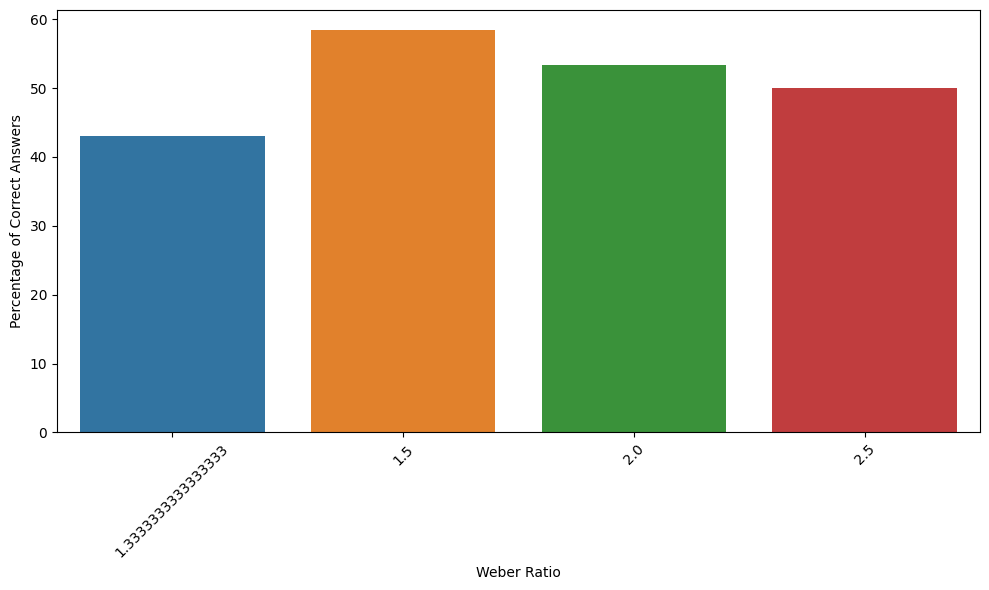

In [12]:
weber_plot = plot_weber_fraction(validation_results)

# Log validation metrics to wandb
if wandb_:
    log_validation_stats_to_wandb(running_loss, total_correct, total, validation_results, weber_plot)
    wandb.finish()

In [21]:
validation_results

In [9]:
from pytorch_model_summary import summary

print(summary(DecodingImagesCNN(), torch.zeros((1, 34, 31, 31)), show_input=True))

---------------------------------------------------------------------------
          Layer (type)         Input Shape         Param #     Tr. Param #
              Conv2d-1     [1, 34, 31, 31]           4,912           4,912
         BatchNorm2d-2     [1, 16, 31, 31]              32              32
             Dropout-3     [1, 16, 15, 15]               0               0
              Conv2d-4     [1, 16, 15, 15]           4,640           4,640
         BatchNorm2d-5     [1, 32, 15, 15]              64              64
              Conv2d-6       [1, 32, 7, 7]          18,496          18,496
         BatchNorm2d-7       [1, 64, 7, 7]             128             128
   AdaptiveAvgPool2d-8       [1, 64, 3, 3]               0               0
              Linear-9             [1, 64]              65              65
Total params: 28,337
Trainable params: 28,337
Non-trainable params: 0
---------------------------------------------------------------------------
